<a href="https://colab.research.google.com/github/el-grudge/mleng-zoomcamp/blob/main/capstone_01/capstone_where_am_i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Write up

Location Determination

The Kaggle dataset [where am i](https://www.kaggle.com/datasets/ahmedhaytham/where-am-i) was created by Ahmed Haytham and Shady Nagy as an assignment during their internship at Curve-AI. They were tasked with building an image dataset from 3 youtube videos showing a car driving in 3 diffierent cities (Cairo, Paris, Moscow) and training an image classifier to predict the city from an image.

For the capstone, I used this dataset to build and deploy an image classifier. Here are 3 sample images from the dataset:

[]
[]
[]

I took the following approach:

1- Building phase: Use transfer learning to build 3 image classifiers on top of 3 architectures, Xception, Inception, and ResNet
2- Training phase: Train 3 classifiers and tune their hyperparameters
3- Deployment phase: Deploy the best performing classifier

Building Phase

Central to this approach is the args namespace. I created 3 namespaces, one for each classifier, to save the hyperparameter values.

The 3 namespaces are then combined in a global namespace that also includes other parameters and flags that I use throughout the training process.

For each architecture I created a class that instantiates a vanilla classifier, using the `build_model` class function. It is also possible to add an extra layer and adjust the dropout rate of the classifier by passing the right parameters to the function call.

I created a custom callback that logs the performance of the model with different parameters and saves them in a dictionary after each epoch, which I appended to a scores dictionary. I used this scores dictionary for 2 things:
1- To generate performance plots
2- To save the best parameter for each architecture.

Training Phase

In the training I started by tuning the learning rate for all 3 classifiers. Once I learned the best lr for each architecture, I moved on to adding an extra layer for to the 3 architectures, and adjusting the droprate.

Afterwards, I used the best hyperparameters for each architecture and used them to train 3 classifiers on augmented images.

Finally, I trained the top 2 classifiers from the previous step using a larger input size (299 instead of 150), and decide which model to deploy.

# Get the data

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/ahmedhaytham/where-am-i")

Skipping, found downloaded files in "./where-am-i" (use force=True to force download)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img

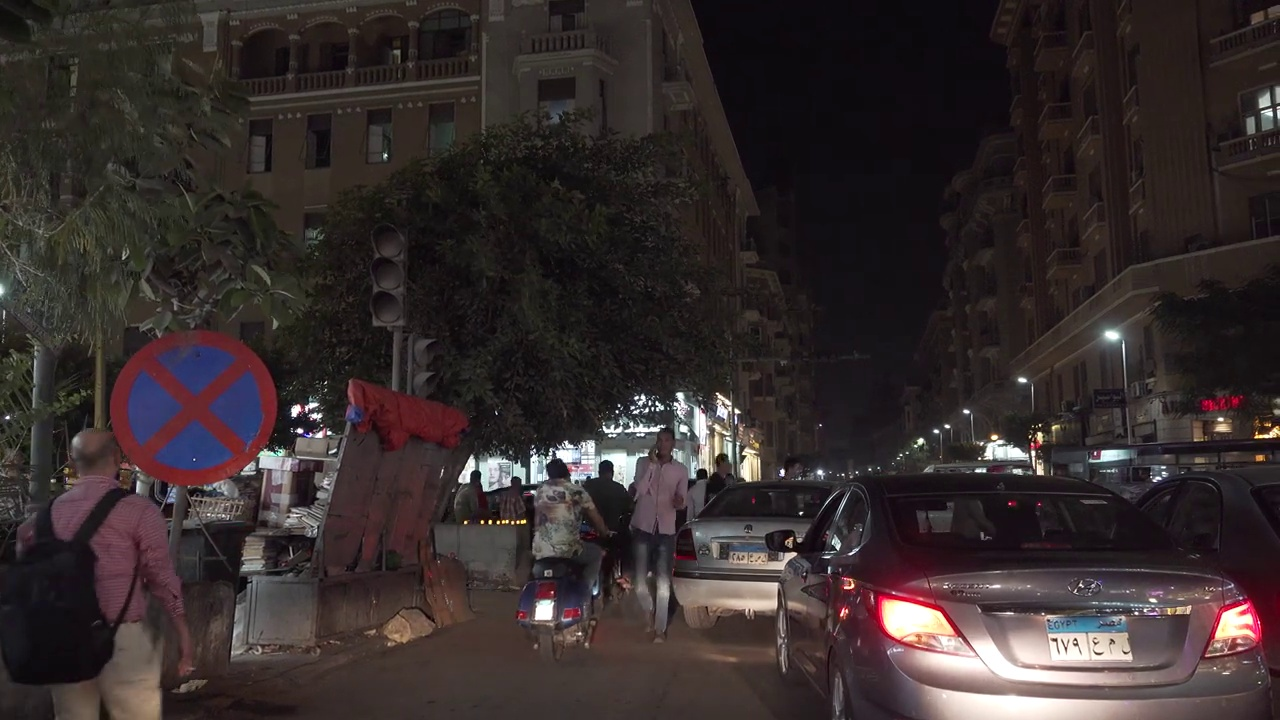

In [ ]:
path = './where-am-i/Data/train/cairo/'
name = 'cairo_frame0.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

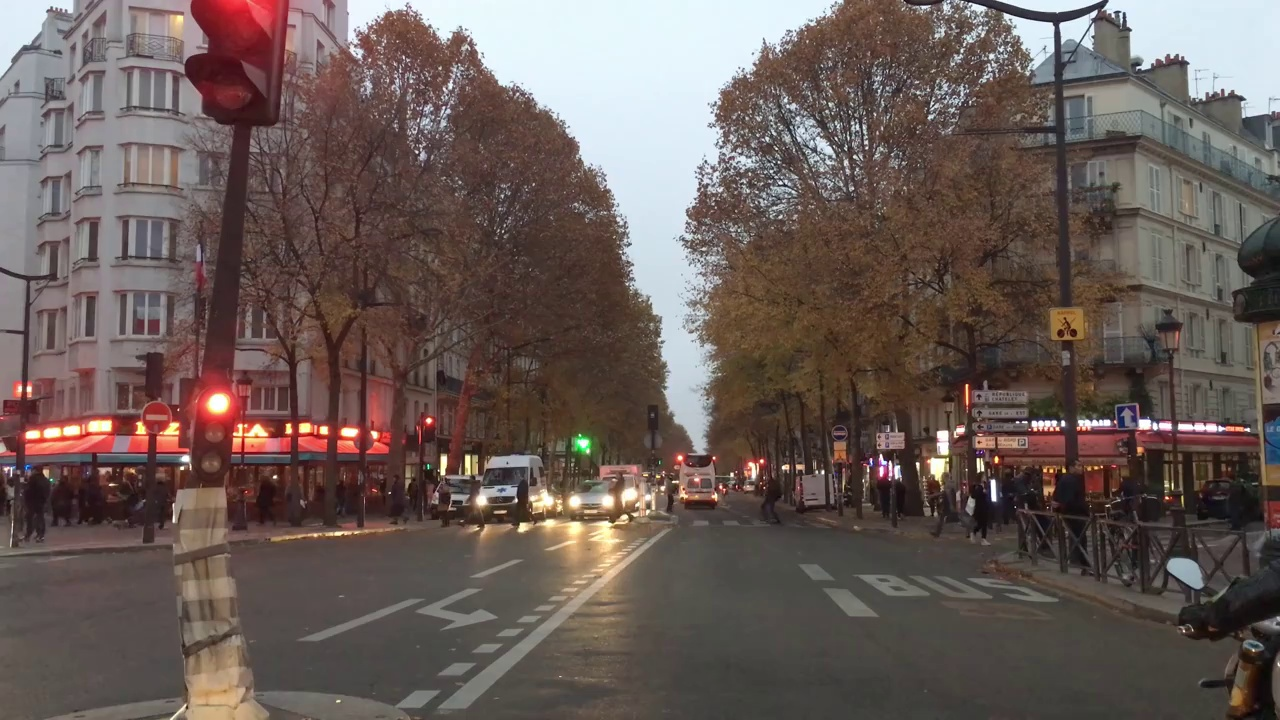

In [ ]:
path = './where-am-i/Data/train/paris/'
name = 'paris_frame10020.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

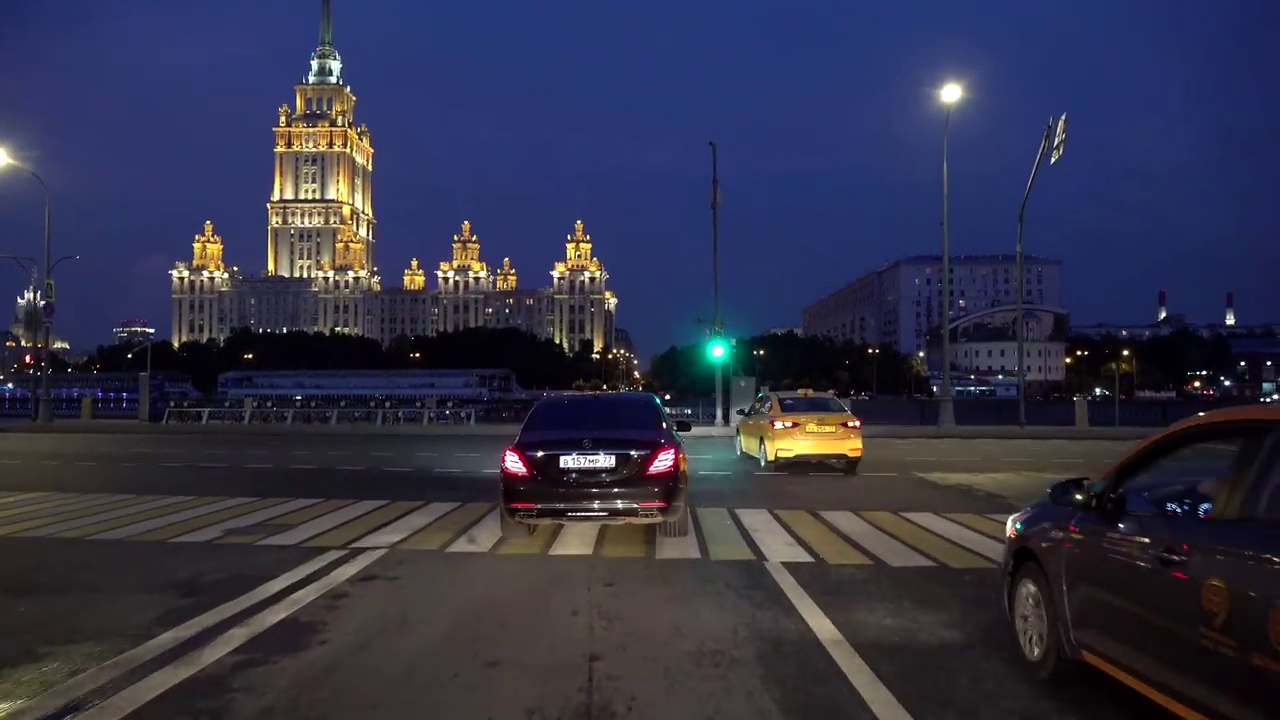

In [ ]:
path = './where-am-i/Data/train/moscow/'
name = 'moscow_frame10140.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

# Models

## Xception

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.applications.xception import Xception


class XceptionModel():
  def __init__(self, input_size=150):
     self.base_model = Xception(
         weights='imagenet',
         include_top=False,
         input_shape=(input_size,input_size,3)
         )

     self.base_model.trainable = False
     self.inputs = keras.Input(shape=(input_size,input_size,3))
     self.base = self.base_model(self.inputs, training=False)
     self.vectors = keras.layers.GlobalAveragePooling2D()(self.base)
     self.outputs = keras.layers.Dense(3)(self.vectors)
     self.model = keras.Model(self.inputs, self.outputs)

  def build_model(self, args, optimizer, loss):
     self.add_layer(args.model_args[args.model].size) if args.model_args[args.model].inner else None
     self.add_dropout(args.model_args[args.model].droprate) if args.model_args[args.model].drop else None
     self.model.compile(optimizer=optimizer, loss=loss, metrics=args.metrics)
     return self.model

  def add_layer(self, size=100):
     self.inner = keras.layers.Dense(units=size, activation='relu', name='inner_layer')(self.vectors)
     self.outputs = keras.layers.Dense(3)(self.inner)
     self.model = keras.Model(self.inputs, self.outputs)

  def add_dropout(self, droprate=0.0):
     self.drop = keras.layers.Dropout(rate=droprate)(self.inner if args.model_args[args.model].inner else self.vectors)
     self.outputs = keras.layers.Dense(3)(self.drop)
     self.model = keras.Model(self.inputs, self.outputs)


## Inception

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

class InceptionModel():
  def __init__(self, input_size=150):
     self.base_model = InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(input_size,input_size,3)
        )

     self.base_model.trainable = False
     self.inputs = keras.Input(shape=(input_size,input_size,3))
     self.base = self.base_model(self.inputs, training=False)
     self.vectors = keras.layers.GlobalAveragePooling2D()(self.base)
     self.outputs = keras.layers.Dense(3)(self.vectors)
     self.model = keras.Model(self.inputs, self.outputs)

  def build_model(self, args, optimizer, loss):
     self.add_layer(args.model_args[args.model].size) if args.model_args[args.model].inner else None
     self.add_dropout(args.model_args[args.model].droprate) if args.model_args[args.model].drop else None
     self.model.compile(optimizer=optimizer, loss=loss, metrics=args.metrics)
     return self.model

  def add_layer(self, size=100):
     self.inner = keras.layers.Dense(units=size, activation='relu', name='inner_layer')(self.vectors)
     self.outputs = keras.layers.Dense(3)(self.inner)
     self.model = keras.Model(self.inputs, self.outputs)

  def add_dropout(self, droprate=0.0):
     self.drop = keras.layers.Dropout(rate=droprate)(self.inner if args.model_args[args.model].inner else self.vectors)
     self.outputs = keras.layers.Dense(3)(self.drop)
     self.model = keras.Model(self.inputs, self.outputs)


## ResNet

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2


class ResNetModel():
  def __init__(self, input_size=150):
     self.base_model = ResNet152V2(
        weights="imagenet",
        include_top=False,
        input_shape=(input_size,input_size,3),
        )

     self.base_model.trainable = False
     self.inputs = keras.Input(shape=(input_size,input_size,3))
     self.base = self.base_model(self.inputs, training=False)
     self.vectors = keras.layers.GlobalAveragePooling2D()(self.base)
     self.outputs = keras.layers.Dense(3)(self.vectors)
     self.model = keras.Model(self.inputs, self.outputs)

  def build_model(self, args, optimizer, loss):
     self.add_layer(args.model_args[args.model].size) if args.model_args[args.model].inner else None
     self.add_dropout(args.model_args[args.model].droprate) if args.model_args[args.model].drop else None
     self.model.compile(optimizer=optimizer, loss=loss, metrics=args.metrics)
     return self.model

  def add_layer(self, size=100):
     self.inner = keras.layers.Dense(units=size, activation='relu', name='inner_layer')(self.vectors)
     self.outputs = keras.layers.Dense(3)(self.inner)
     self.model = keras.Model(self.inputs, self.outputs)

  def add_dropout(self, droprate=0.0):
     self.drop = keras.layers.Dropout(rate=droprate)(self.inner if args.model_args[args.model].inner else self.vectors)
     self.outputs = keras.layers.Dense(3)(self.drop)
     self.model = keras.Model(self.inputs, self.outputs)


# Custom callback

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Custom callback to collect training information
class CustomCallback(Callback):
    def __init__(self, args):
        super().__init__()
        self.data = {
            'Model': [],
            'LearningRate': [],
            'ExtraLayer': [],
            'Droprate': [],
            'Augmentation': [],
            'ModelSize': [],
            'ValidationAccuracy': []
            }
        self.model_architecture = args.model # Assuming args.model contains the model architecture
        self.inner = args.model_args[args.model].inner
        self.drop = args.model_args[args.model].drop
        self.augmentation = args.augmentation
        self.input_size = args.input_size

    def on_epoch_end(self, epoch, logs):
        # Extract information from the model or training logs
        model_architecture = self.model_architecture # Assuming args.model contains the model architecture
        learning_rate = self.model.optimizer.lr.numpy() if hasattr(self.model.optimizer, 'lr') else 'NA'
        extra_layer = [layer for layer in self.model.layers if 'inner' in layer.name][0].output_shape[1] if self.inner else 'NA'
        droprate =  [layer for layer in self.model.layers if 'drop' in layer.name][0].rate if self.drop else 'NA'
        augmentation = self.augmentation
        input_size = self.input_size
        val_accuracy = logs.get('val_accuracy', 'NA')  # You need to replace this with the actual value

        # Append the information to the data dictionary
        self.data['Model'].append(model_architecture)
        self.data['LearningRate'].append(learning_rate)
        self.data['ExtraLayer'].append(extra_layer)
        self.data['Droprate'].append(droprate)
        self.data['Augmentation'].append(augmentation)
        self.data['ModelSize'].append(input_size)
        self.data['ValidationAccuracy'].append(val_accuracy)


# Utilities

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input


def load_dataset(args, location, split='train'):
   preprocess_function = {
      'Xception': xception_preprocess_input,
      'Inception': inception_preprocess_input,
      'ResNet': resnet_preprocess_input
      }

   if split != 'train':
    generator = ImageDataGenerator(preprocessing_function = preprocess_function[args.model])
   else:
    generator = ImageDataGenerator(
        preprocessing_function = preprocess_function[args.model],
        rotation_range = args.augmentation_args['rotation_range'] if args.augmentation else 0,
        height_shift_range = args.augmentation_args['height_shift_range'] if args.augmentation else 0.0,
        width_shift_range = args.augmentation_args['width_shift_range'] if args.augmentation else 0.0,
        horizontal_flip = args.augmentation_args['horizontal_flip'] if args.augmentation else False,
        vertical_flip = args.augmentation_args['vertical_flip'] if args.augmentation else False,
        zoom_range = args.augmentation_args['zoom_range'] if args.augmentation else 1.0
        )

   dataset = generator.flow_from_directory(
       location,
       target_size=(args.input_size, args.input_size),
       batch_size=args.batch_size,
       shuffle=False if split != 'train' else args.shuffle
       )

   return dataset


def create_model(args):
  models = {
     'Xception': XceptionModel(args.input_size),
     'Inception': InceptionModel(args.input_size),
     'ResNet': ResNetModel(args.input_size)
  }

  optimizer = keras.optimizers.Adam(learning_rate=args.model_args[args.model].learning_rate)

  loss = keras.losses.CategoricalCrossentropy(from_logits=True)

  model = models[args.model]

  model.build_model(args, optimizer, loss)

  return model


def append_scores(scores_dict, results):
  if not bool(scores_dict):
    scores_dict = results
  else:
    for key in scores_dict.keys():
      scores_dict[key].extend(results[key])

  return scores_dict



# Main

## setup

In [ ]:
import numpy as np
import pandas as pd
from argparse import Namespace
import matplotlib.pyplot as plt

In [ ]:
xception_args = Namespace(
    model = 'Xception',
    learning_rate=None,
    inner=False,
    size=None,
    drop=False,
    droprate=None
    )

inception_args = Namespace(
    model = 'Inception',
    learning_rate=None,
    inner=False,
    size=None,
    drop=False,
    droprate=None
    )

resnet_args = Namespace(
    model = 'ResNet',
    learning_rate=None,
    inner=False,
    size=None,
    drop=False,
    droprate=None
    )

In [ ]:
args = Namespace(
    model = "",
    model_args = {
        'Xception': xception_args,
        'Inception': inception_args,
        'ResNet': resnet_args,
    },
    epochs=10,
    batch_size=32,
    input_size=150,
    shuffle=False,
    metrics = ['accuracy'],
    augmentation=False,
    augmentation_args = {
        'rotation_range':50,
        'height_shift_range':0.1,
        'width_shift_range':0.1,
        'horizontal_flip':True,
        'vertical_flip':True,
        'zoom_range':0.1
    }
)

In [ ]:
path = './where-am-i/Data'
fullpath = f'{path}'

train_location = f'{fullpath}/train'
val_location = f'{fullpath}/Val'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## adjust learning rate

In [ ]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
architectures = ['Xception', 'Inception', 'ResNet']
scores_dict = {}

In [22]:
# adjusting learning rate
for lr in [0.001, 0.01, 0.1]:
  for architecture in architectures:
    args.model = architecture
    args.model_args[architecture].learning_rate = lr

    train_dataset = load_dataset(args, train_location, 'train')
    val_dataset = load_dataset(args, val_location, 'val')
    model = create_model(args)

    checkpoint_format = f"models/{args.model}_lr_{args.model_args[architecture].learning_rate}_{{epoch:02d}}_{{val_accuracy:.3f}}.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_format,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
        )

    custom_callback = CustomCallback(args)
    history = model.model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[custom_callback, checkpoint])
    scores_dict = append_scores(scores_dict, custom_callback.data)

    print()
    print()

print("the end")



Found 1800 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
234545216/234545216 [==============================] - 7s 0us/step
Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 1.0460 - accuracy: 0.5400

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 26s 369ms/step - loss: 1.0460 - accuracy: 0.5400 - val_loss: 0.8291 - val_accuracy: 0.6767
Epoch 2/10
57/57 [==============================] - 20s 358ms/step - loss: 0.6287 - accuracy: 0.7544 - val_loss: 0.7471 - val_accuracy: 0.7067
Epoch 3/10
57/57 [==============================] - 20s 345ms/step - loss: 0.4689 - accuracy: 0.8194 - val_loss: 0.8255 - val_accuracy: 0.5933
Epoch 4/10
57/57 [==============================] - 20s 347ms/step - loss: 0.4027 - accuracy: 0.8550 - val_loss: 0.8192 - val_accuracy: 0.6000
Epoch 5/10
57/57 [==============================] - 20s 347ms/step - loss: 0.3703 - accuracy: 0.8700 - val_loss: 0.8290 - val_accuracy: 0.6067
Epoch 6/10
57/57 [==============================] - 20s 346ms/step - loss: 0.3381 - accuracy: 0.8850 - val_loss: 0.6974 - val_accuracy: 0.6833
Epoch 7/10
57/57 [==============================] - 19s 337ms/step - loss: 0.3150 - accuracy: 0.8950 - val_loss: 0.9287 - val_accuracy: 0.5833
Epoch 8/10

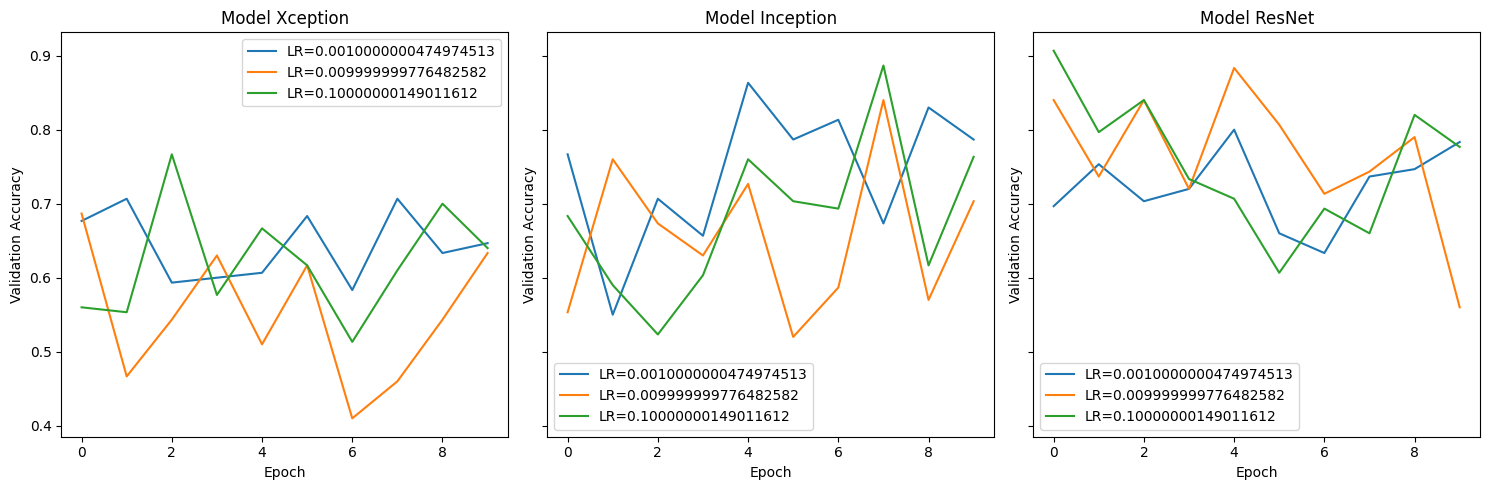

In [24]:
# Create a facet wrap plot
df = pd.DataFrame(scores_dict)
models = df['Model'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 5), sharey=True)

for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    unique_lr = model_data['LearningRate'].unique()

    for lr in unique_lr:
        lr_data = model_data[model_data['LearningRate'] == lr]
        validation_accuracy = lr_data['ValidationAccuracy']
        axes[i].plot(np.arange(len(validation_accuracy)), validation_accuracy, label=f'LR={lr}')

    axes[i].set_title(f'Model {model}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Validation Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

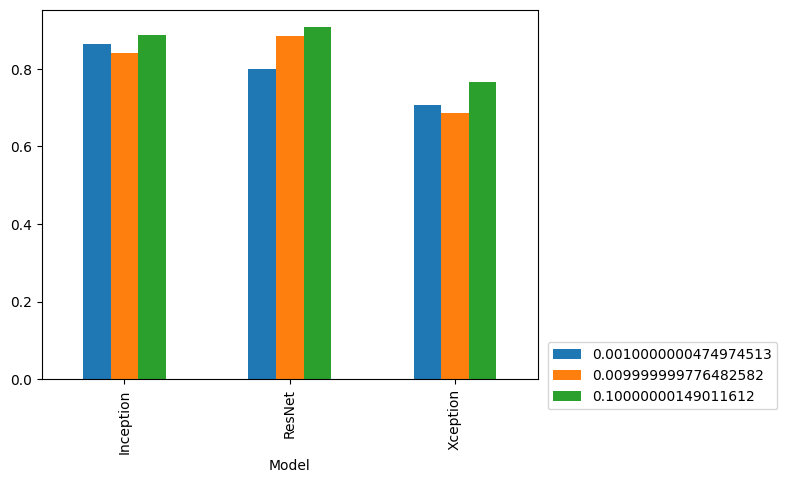

In [25]:
df = pd.DataFrame(scores_dict)
df = df.groupby(['Model', 'LearningRate']).agg({'ValidationAccuracy': 'max'}).unstack()
df.columns = df.columns.droplevel(0)
df = df.reset_index()
df.set_index('Model', inplace=True)
# Plotting
ax = df.plot(kind='bar', stacked=False)
plt.xlabel('Model')  # This sets the x-axis label
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)
plt.show()


In [26]:
pd.DataFrame(scores_dict).groupby('Model').\
apply(lambda x: x.loc[x['ValidationAccuracy'].idxmax()])

Model  LearningRate ExtraLayer Droprate  Augmentation  \
Model                                                                  
Inception  Inception           0.1         NA       NA         False   
ResNet        ResNet           0.1         NA       NA         False   
Xception    Xception           0.1         NA       NA         False   

           ModelSize  ValidationAccuracy  
Model                                     
Inception        150            0.886667  
ResNet           150            0.906667  
Xception         150            0.766667

In [27]:
scores_df = pd.DataFrame(scores_dict)

for architecture in architectures:
  df = scores_df[scores_df['Model'] == architecture]
  args.model_args[architecture].learning_rate = \
  df.loc[df['ValidationAccuracy'].idxmax()].LearningRate

In [28]:
[(architecture, args.model_args[architecture].learning_rate) for architecture in architectures]

[('Xception', 0.1), ('Inception', 0.1), ('ResNet', 0.1)]

In [29]:
scores_df.to_csv('scores.csv', index=False)

In [30]:
tf.keras.backend.clear_session()

In [31]:
# copy it there
!cp models/Inception_lr_0.1_08_0.887.h5 /content/drive/MyDrive/mlzoomcamp_capstone/models
!cp models/ResNet_lr_0.1_01_0.907.h5 /content/drive/MyDrive/mlzoomcamp_capstone/models
!cp models/Xception_lr_0.1_03_0.767.h5 /content/drive/MyDrive/mlzoomcamp_capstone/models
!cp scores.csv /content/drive/MyDrive/mlzoomcamp_capstone

## add extra layer

In [32]:
# adding extra layer
for size in [10, 100, 1000]:
  for architecture in architectures:
    args.model = architecture
    args.model_args[architecture].inner = True
    args.model_args[architecture].size = size

    train_dataset = load_dataset(args, train_location, 'train')
    val_dataset = load_dataset(args, val_location, 'val')
    model = create_model(args)
    inner_layer =  [layer.name for layer in model.model.layers if 'inner' in layer.name]
    print(size, model.model.layers[1].name)

    checkpoint_format = f"models/{args.model}_lr_{args.model_args[architecture].learning_rate}_size_{args.model_args[architecture].size}_{{epoch:02d}}_{{val_accuracy:.3f}}.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_format,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
        )

    custom_callback = CustomCallback(args)
    history = model.model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[custom_callback, checkpoint])
    scores_dict = append_scores(scores_dict, custom_callback.data)

    print()
    print()

print("the end")

Found 1800 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
10 xception
Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 6.0144 - accuracy: 0.3033

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 24s 362ms/step - loss: 6.0144 - accuracy: 0.3033 - val_loss: 1.1041 - val_accuracy: 0.3333
Epoch 2/10
57/57 [==============================] - 20s 348ms/step - loss: 1.1535 - accuracy: 0.3378 - val_loss: 1.1063 - val_accuracy: 0.3333
Epoch 3/10
57/57 [==============================] - 21s 361ms/step - loss: 1.1697 - accuracy: 0.2933 - val_loss: 1.1072 - val_accuracy: 0.3333
Epoch 4/10
57/57 [==============================] - 20s 353ms/step - loss: 1.1558 - accuracy: 0.2800 - val_loss: 1.1109 - val_accuracy: 0.3333
Epoch 5/10
57/57 [==============================] - 20s 352ms/step - loss: 1.1414 - accuracy: 0.3467 - val_loss: 1.1167 - val_accuracy: 0.3333
Epoch 6/10
57/57 [==============================] - 20s 352ms/step - loss: 1.1537 - accuracy: 0.2622 - val_loss: 1.1027 - val_accuracy: 0.3333
Epoch 7/10
57/57 [==============================] - 20s 348ms/step - loss: 1.1361 - accuracy: 0.2978 - val_loss: 1.1091 - val_accuracy: 0.3333
Epoch 8/10

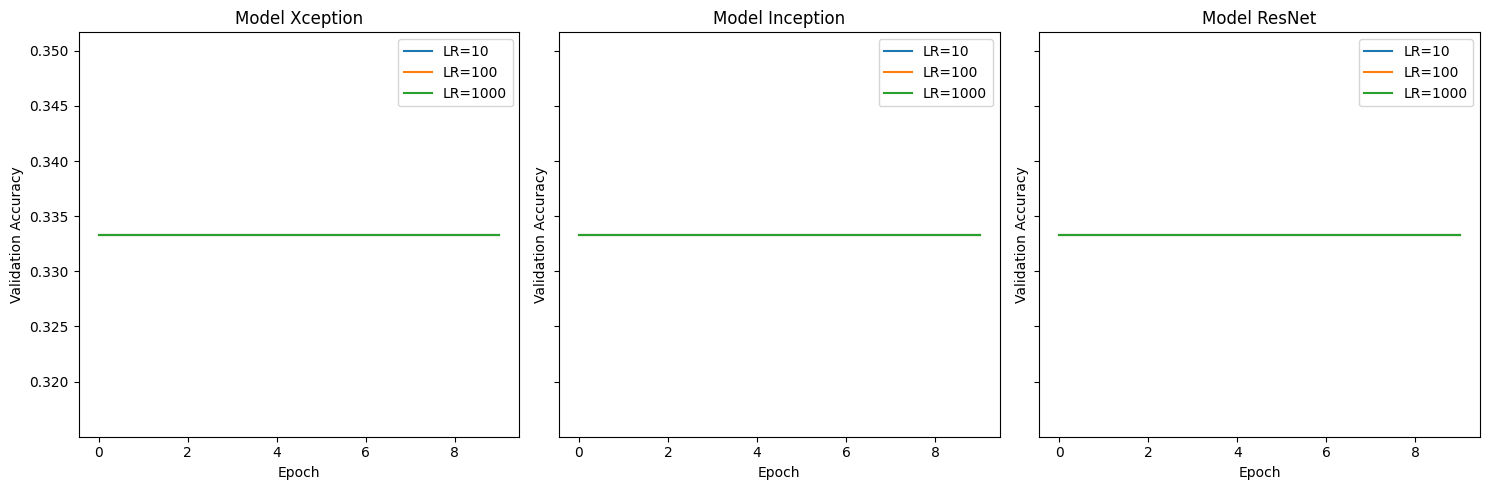

In [33]:
# Create a facet wrap plot
df = pd.DataFrame(scores_dict)[pd.DataFrame(scores_dict)['ExtraLayer'] != 'NA']
models = df['Model'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 5), sharey=True)

for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    unique_lr = model_data['ExtraLayer'].unique()

    for lr in unique_lr:
        lr_data = model_data[model_data['ExtraLayer'] == lr]
        validation_accuracy = lr_data['ValidationAccuracy']
        axes[i].plot(np.arange(len(validation_accuracy)), validation_accuracy, label=f'LR={lr}')

    axes[i].set_title(f'Model {model}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Validation Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()


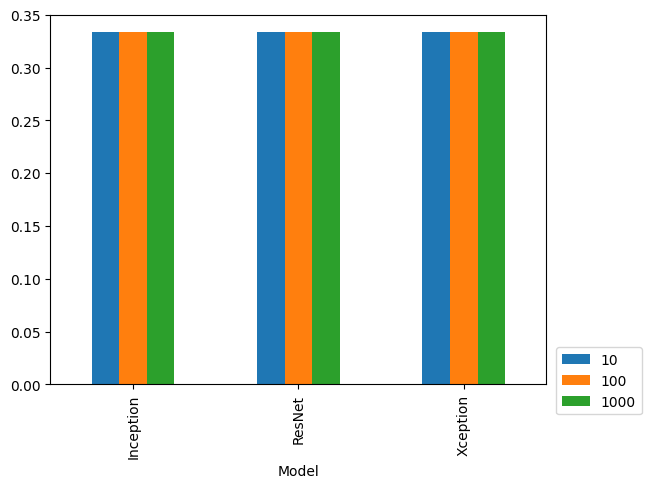

In [35]:
df = pd.DataFrame(scores_dict)[pd.DataFrame(scores_dict)['ExtraLayer'] != 'NA']
df = df.groupby(['Model', 'ExtraLayer']).agg({'ValidationAccuracy': 'max'}).unstack()
df.columns = df.columns.droplevel(0)
df = df.reset_index()
df.set_index('Model', inplace=True)
# Plotting
ax = df.plot(kind='bar', stacked=False)
plt.xlabel('Model')  # This sets the x-axis label
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)
plt.show()


In [36]:
pd.DataFrame(scores_dict).groupby('Model').\
apply(lambda x: x.loc[x['ValidationAccuracy'].idxmax()])

Model  LearningRate ExtraLayer Droprate  Augmentation  \
Model                                                                  
Inception  Inception           0.1         NA       NA         False   
ResNet        ResNet           0.1         NA       NA         False   
Xception    Xception           0.1         NA       NA         False   

           ModelSize  ValidationAccuracy  
Model                                     
Inception        150            0.886667  
ResNet           150            0.906667  
Xception         150            0.766667

In [37]:
scores_df = pd.DataFrame(scores_dict)

for architecture in architectures:
  df = scores_df[(scores_df['Model'] == architecture)]
  inner = df.loc[df['ValidationAccuracy'].idxmax()].ExtraLayer
  args.model_args[architecture].inner = True if inner != 'NA' else False
  args.model_args[architecture].size = inner if inner != 'NA' else 'NA'

In [38]:
[(architecture, args.model_args[architecture].size) for architecture in architectures]

[('Xception', 'NA'), ('Inception', 'NA'), ('ResNet', 'NA')]

In [39]:
scores_df.to_csv('scores.csv', index=False)

In [40]:
tf.keras.backend.clear_session()

In [41]:
# copy it there
# !cp models/* /content/drive/MyDrive
# !cp scores.csv /content/drive/MyDrive

## adjust droprate

In [42]:
# adjusting droprate

for droprate in [.2, .5, .8]:
  for architecture in architectures:
    args.model = architecture
    args.model_args[architecture].drop = True
    args.model_args[architecture].droprate = droprate

    train_dataset = load_dataset(args, train_location, 'train')
    val_dataset = load_dataset(args, val_location, 'val')
    model = create_model(args)
    # inner_layer = [layer.name for layer in model.model.layers if 'inner' in layer.name]
    drop_layer = [layer.name for layer in model.model.layers if 'dropout' in layer.name]
    print(droprate, model.model.layers[1].name)

    checkpoint_format = f"models/{args.model}_lr_{args.model_args[architecture].learning_rate}_size_{args.model_args[architecture].size}_dropout_{args.model_args[architecture].droprate}_{{epoch:02d}}_{{val_accuracy:.3f}}.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_format,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
        )

    custom_callback = CustomCallback(args)
    history = model.model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[custom_callback, checkpoint])
    scores_dict = append_scores(scores_dict, custom_callback.data)

    print()
    print()

print("the end")

Found 1800 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
0.2 xception
Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 23.4945 - accuracy: 0.6072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 24s 364ms/step - loss: 23.4945 - accuracy: 0.6072 - val_loss: 6.7528 - val_accuracy: 0.7167
Epoch 2/10
57/57 [==============================] - 20s 355ms/step - loss: 4.1260 - accuracy: 0.8333 - val_loss: 19.0632 - val_accuracy: 0.4567
Epoch 3/10
57/57 [==============================] - 20s 355ms/step - loss: 4.7349 - accuracy: 0.7994 - val_loss: 17.1173 - val_accuracy: 0.4967
Epoch 4/10
57/57 [==============================] - 20s 360ms/step - loss: 2.4466 - accuracy: 0.8733 - val_loss: 3.9233 - val_accuracy: 0.7933
Epoch 5/10
57/57 [==============================] - 20s 350ms/step - loss: 5.1498 - accuracy: 0.8417 - val_loss: 5.2150 - val_accuracy: 0.7467
Epoch 6/10
57/57 [==============================] - 20s 351ms/step - loss: 2.8263 - accuracy: 0.8967 - val_loss: 4.9956 - val_accuracy: 0.7533
Epoch 7/10
57/57 [==============================] - 20s 344ms/step - loss: 3.4251 - accuracy: 0.8833 - val_loss: 55.7229 - val_accuracy: 0.4067
Epoch 

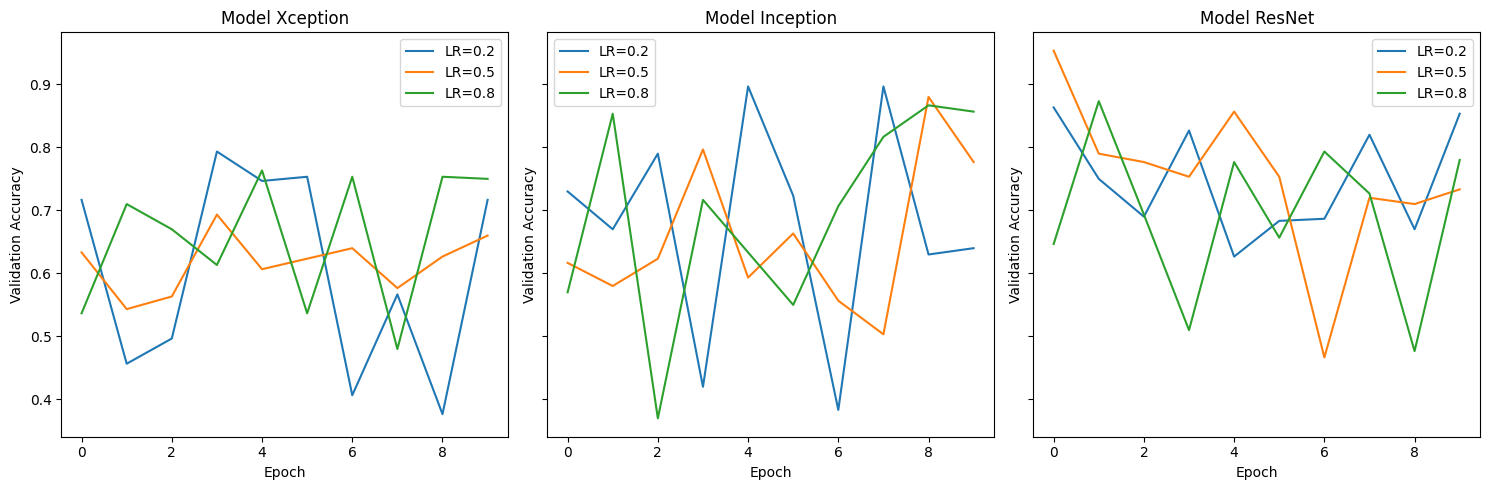

In [43]:
# Create a facet wrap plot
df = pd.DataFrame(scores_dict)[pd.DataFrame(scores_dict)['Droprate'] != 'NA']
models = df['Model'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 5), sharey=True)

for i, model in enumerate(models):
    model_data = df[df['Model'] == model]
    unique_lr = model_data['Droprate'].unique()

    for lr in unique_lr:
        lr_data = model_data[model_data['Droprate'] == lr]
        validation_accuracy = lr_data['ValidationAccuracy']
        axes[i].plot(np.arange(len(validation_accuracy)), validation_accuracy, label=f'LR={lr}')

    axes[i].set_title(f'Model {model}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Validation Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()


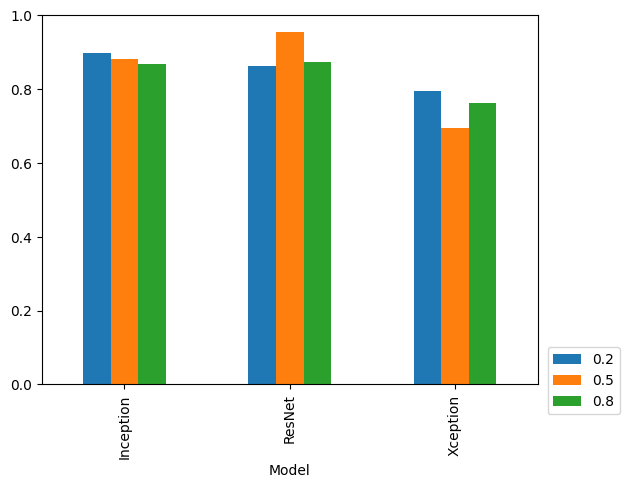

In [44]:
df = pd.DataFrame(scores_dict)[pd.DataFrame(scores_dict)['Droprate'] != 'NA']
df = df.groupby(['Model', 'Droprate']).agg({'ValidationAccuracy': 'max'}).unstack()
df.columns = df.columns.droplevel(0)
df = df.reset_index()
df.set_index('Model', inplace=True)
# Plotting
ax = df.plot(kind='bar', stacked=False)
plt.xlabel('Model')  # This sets the x-axis label
plt.legend(bbox_to_anchor=(1.02, 0.1), loc='upper left', borderaxespad=0)
plt.show()


In [45]:
pd.DataFrame(scores_dict).groupby('Model').\
apply(lambda x: x.loc[x['ValidationAccuracy'].idxmax()])

Model  LearningRate ExtraLayer  Droprate  Augmentation  \
Model                                                                   
Inception  Inception           0.1         NA       0.2         False   
ResNet        ResNet           0.1         NA       0.5         False   
Xception    Xception           0.1         NA       0.2         False   

           ModelSize  ValidationAccuracy  
Model                                     
Inception        150            0.896667  
ResNet           150            0.953333  
Xception         150            0.793333

In [46]:
scores_df = pd.DataFrame(scores_dict)

for architecture in architectures:
  df = scores_df[(scores_df['Model'] == architecture)]
  droprate = df.loc[df['ValidationAccuracy'].idxmax()].Droprate
  args.model_args[architecture].drop = True if droprate != 'NA' else False
  args.model_args[architecture].droprate = droprate if droprate != 'NA' else 'NA'

In [47]:
[(architecture, args.model_args[architecture].droprate) for architecture in architectures]

[('Xception', 0.2), ('Inception', 0.2), ('ResNet', 0.5)]

In [48]:
scores_df.to_csv('scores.csv', index=False)

In [49]:
tf.keras.backend.clear_session()

In [50]:
# copy it there
!cp models/Inception_lr_0.10000000149011612_size_NA_dropout_0.2_05_0.897.h5 /content/drive/MyDrive/mlzoomcamp_capstone/models
!cp models/ResNet_lr_0.10000000149011612_size_NA_dropout_0.5_01_0.953.h5 /content/drive/MyDrive/mlzoomcamp_capstone/models
!cp models/Xception_lr_0.10000000149011612_size_NA_dropout_0.2_04_0.793.h5 /content/drive/MyDrive/mlzoomcamp_capstone/models
!cp scores.csv /content/drive/MyDrive

## augmentation

In [51]:
args.model_args

{'Xception': Namespace(model='Xception', learning_rate=0.1, inner=False, size='NA', drop=True, droprate=0.2),
 'Inception': Namespace(model='Inception', learning_rate=0.1, inner=False, size='NA', drop=True, droprate=0.2),
 'ResNet': Namespace(model='ResNet', learning_rate=0.1, inner=False, size='NA', drop=True, droprate=0.5)}

In [52]:
# adding augmentation

for architecture in architectures:
  args.model = architecture
  args.augmentation=True
  args.shuffle=True
  train_dataset = load_dataset(args, train_location, 'train')
  val_dataset = load_dataset(args, val_location, 'val')
  model = create_model(args)

  checkpoint_format = f"models/{args.model}_lr_{args.model_args[architecture].learning_rate}_size_{args.model_args[architecture].size}_dropout_{args.model_args[architecture].droprate}_{{epoch:02d}}_{{val_accuracy:.3f}}_augmented.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(
      checkpoint_format,
      save_best_only=True,
      monitor='val_accuracy',
      mode='max'
      )

  custom_callback = CustomCallback(args)
  history = model.model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[custom_callback, checkpoint])
  scores_dict = append_scores(scores_dict, custom_callback.data)

  print()
  print()

print("the end")

Found 1800 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 2.9159 - accuracy: 0.8539

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 24s 375ms/step - loss: 2.9159 - accuracy: 0.8539 - val_loss: 13.0450 - val_accuracy: 0.4967
Epoch 2/10
57/57 [==============================] - 21s 361ms/step - loss: 0.9304 - accuracy: 0.9439 - val_loss: 5.4329 - val_accuracy: 0.6500
Epoch 3/10
57/57 [==============================] - 21s 362ms/step - loss: 0.9353 - accuracy: 0.9350 - val_loss: 13.6502 - val_accuracy: 0.5533
Epoch 4/10
57/57 [==============================] - 20s 355ms/step - loss: 1.0843 - accuracy: 0.9456 - val_loss: 17.1085 - val_accuracy: 0.4867
Epoch 5/10
57/57 [==============================] - 21s 368ms/step - loss: 0.8072 - accuracy: 0.9550 - val_loss: 9.0210 - val_accuracy: 0.7033
Epoch 6/10
57/57 [==============================] - 20s 359ms/step - loss: 0.9883 - accuracy: 0.9556 - val_loss: 18.1259 - val_accuracy: 0.5500
Epoch 7/10
57/57 [==============================] - 20s 357ms/step - loss: 0.5362 - accuracy: 0.9694 - val_loss: 8.6276 - val_accuracy: 0.7300
Epoch 

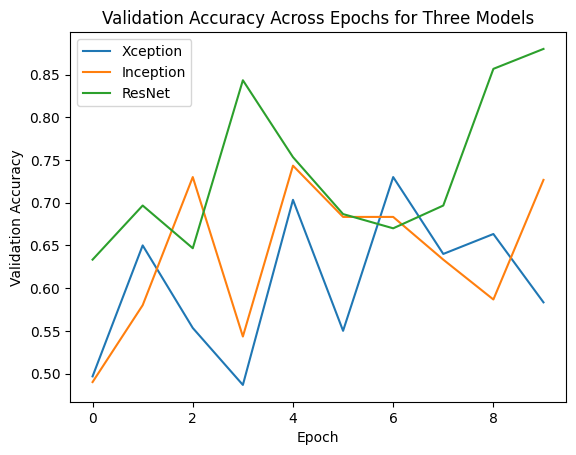

In [62]:
# Create a facet wrap plot
df = pd.DataFrame(scores_dict)[pd.DataFrame(scores_dict)['Augmentation'] != False]
models = df['Model'].unique()

# Plotting
fig, ax = plt.subplots()

# Use a for loop to plot lines for each model
for model in models:
    model_df = df[df['Model'] == model]
    ax.plot(np.arange(10), model_df['ValidationAccuracy'], label=model)

# Adding labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy Across Epochs for Three Models')

# Adding legend
ax.legend()

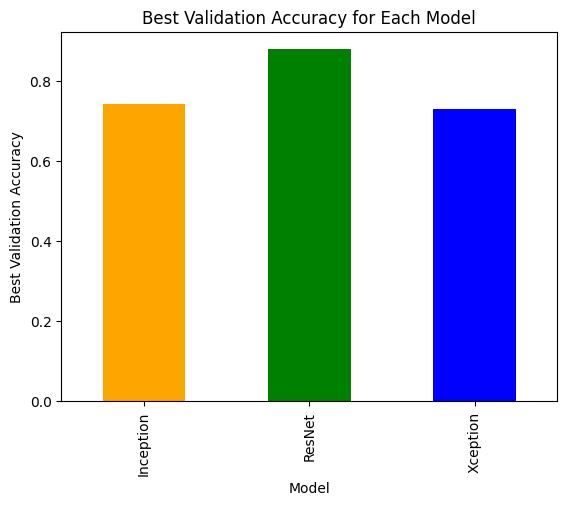

In [66]:
# Grouping by 'Model' and finding the maximum validation accuracy for each model
best_performances = df.groupby('Model')['ValidationAccuracy'].max()

# Plotting a bar chart
fig, ax = plt.subplots()
best_performances.plot(kind='bar', ax=ax, color=['orange', 'green', 'blue'])

# Adding labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Best Validation Accuracy')
ax.set_title('Best Validation Accuracy for Each Model')

# Display the plot
plt.show()


In [67]:
pd.DataFrame(scores_dict).groupby('Model').\
apply(lambda x: x.loc[x['ValidationAccuracy'].idxmax()]).head(2)

Model  LearningRate ExtraLayer  Droprate  Augmentation  \
Model                                                                   
Inception  Inception           0.1         NA       0.2         False   
ResNet        ResNet           0.1         NA       0.5         False   

           ModelSize  ValidationAccuracy  
Model                                     
Inception        150            0.896667  
ResNet           150            0.953333

In [68]:
architectures = list(pd.DataFrame(scores_dict).groupby('Model').\
                     apply(lambda x: x.loc[x['ValidationAccuracy'].idxmax()]).head(2)['Model'])

In [69]:
scores_df.to_csv('scores.csv', index=False)

In [70]:
tf.keras.backend.clear_session()

In [ ]:
# copy it there
# !cp models/* /content/drive/MyDrive
# !cp scores.csv /content/drive/MyDrive

## larger model

In [71]:
# training a larger model
args.epochs = 20

for architecture in architectures:
  args.model = architecture
  args.augmentation=True
  args.shuffle=True
  args.input_size=299
  train_dataset = load_dataset(args, train_location, 'train')
  val_dataset = load_dataset(args, val_location, 'val')
  model = create_model(args)

  checkpoint_format = f"models/{args.model}_lr_{args.model_args[architecture].learning_rate}_size_{args.model_args[architecture].size}_dropout_{args.model_args[architecture].droprate}_{{epoch:02d}}_{{val_accuracy:.3f}}_large_model.h5"
  checkpoint = keras.callbacks.ModelCheckpoint(
      checkpoint_format,
      save_best_only=True,
      monitor='val_accuracy',
      mode='max'
      )

  custom_callback = CustomCallback(args)
  history = model.model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[custom_callback, checkpoint])
  scores_dict = append_scores(scores_dict, custom_callback.data)

  print()
  print()

print("the end")

Found 1800 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 4.9824 - accuracy: 0.7956

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 54s 845ms/step - loss: 4.9824 - accuracy: 0.7956 - val_loss: 18.4835 - val_accuracy: 0.5233
Epoch 2/20
57/57 [==============================] - 47s 822ms/step - loss: 0.8735 - accuracy: 0.9272 - val_loss: 7.5780 - val_accuracy: 0.6333
Epoch 3/20
57/57 [==============================] - 46s 800ms/step - loss: 0.2723 - accuracy: 0.9711 - val_loss: 7.6093 - val_accuracy: 0.6500
Epoch 4/20
57/57 [==============================] - 45s 791ms/step - loss: 0.2710 - accuracy: 0.9717 - val_loss: 16.6535 - val_accuracy: 0.5200
Epoch 5/20
57/57 [==============================] - 46s 804ms/step - loss: 0.4029 - accuracy: 0.9667 - val_loss: 3.1796 - val_accuracy: 0.7833
Epoch 6/20
57/57 [==============================] - 45s 788ms/step - loss: 0.1837 - accuracy: 0.9811 - val_loss: 14.3976 - val_accuracy: 0.5400
Epoch 7/20
57/57 [==============================] - 45s 790ms/step - loss: 0.3009 - accuracy: 0.9722 - val_loss: 3.3083 - val_accuracy: 0.7933
Epoch 8

In [73]:
final_scores_df = pd.DataFrame(scores_dict)[pd.DataFrame(scores_dict)['ModelSize'] == 299]

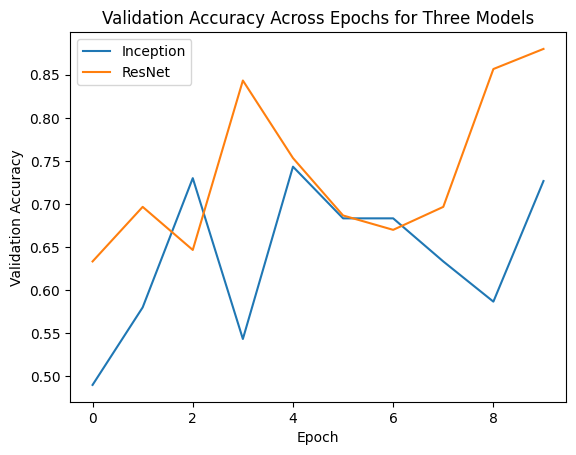

In [74]:
# Create a facet wrap plot
models = final_scores_df['Model'].unique()

# Plotting
fig, ax = plt.subplots()

# Use a for loop to plot lines for each model
for model in models:
    model_df = df[df['Model'] == model]
    ax.plot(np.arange(10), model_df['ValidationAccuracy'], label=model)

# Adding labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy Across Epochs for Three Models')

# Adding legend
ax.legend()

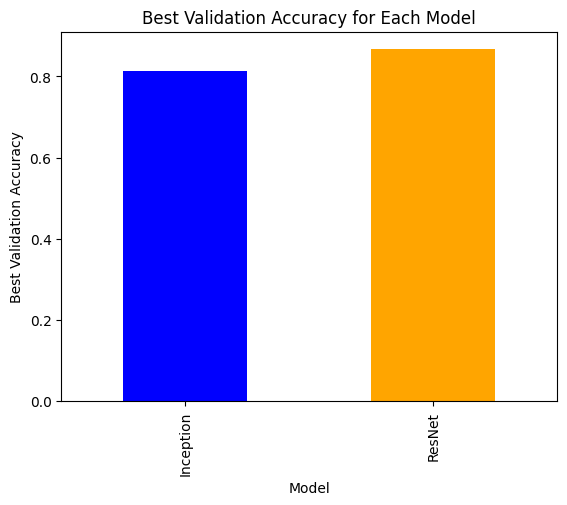

In [77]:
# Grouping by 'Model' and finding the maximum validation accuracy for each model
best_performances = final_scores_df.groupby('Model')['ValidationAccuracy'].max()

# Plotting a bar chart
fig, ax = plt.subplots()
best_performances.plot(kind='bar', ax=ax, color=['blue', 'orange'])

# Adding labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Best Validation Accuracy')
ax.set_title('Best Validation Accuracy for Each Model')

# Display the plot
plt.show()


In [88]:
scores_df = pd.DataFrame(scores_dict)

best model parameters

In [90]:
print(scores_df[scores_df.ValidationAccuracy == scores_df.ValidationAccuracy.max()])

      Model  LearningRate ExtraLayer Droprate  Augmentation  ModelSize  \
230  ResNet           0.1         NA      0.5         False        150   

     ValidationAccuracy  
230            0.953333  


In [91]:
!cp models/ResNet_lr_0.10000000149011612_size_NA_dropout_0.5_01_0.953.h5 /content/drive/MyDrive/mlzoomcamp_capstone/models